# 1.Load data

In [5]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import requests

from prophet import Prophet
from bs4 import BeautifulSoup
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

$$y(t) = g(t) + s(t) + h(t) + \epsilon_
{t}$$


- $g(t)$ - trend
- $s(t)$ - season components
- $h(t)$ - holidays
- $\epsilon_
{t}$ - error

In [6]:
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=21.12.2023'

data = requests.get(URL).text

beautiful_soup = BeautifulSoup(data, "html.parser")
tables = beautiful_soup.find_all("table")

df = pd.read_html(str(tables))[0]
df.iloc[:, 1:] /= 100

In [7]:
def check(data):
    if '202' in str(data).split('.'):
        return str(data) + '0'
    return str(data)

In [122]:
df

ds     y
0    2013-09-17   5.5
1    2013-09-18   5.5
2    2013-09-19   5.5
3    2013-09-20   5.5
4    2013-09-23   5.5
...         ...   ...
2554 2023-12-15  15.0
2555 2023-12-18  16.0
2556 2023-12-19  16.0
2557 2023-12-20  16.0
2558 2023-12-21  16.0

[2559 rows x 2 columns]

In [126]:
df.to_csv('data/key_rate.csv')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/maksimfomin/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/65/m0n5yb356zg5yw45tc1gq3m00000gn/T/ipykernel_11376/2075910249.py", line 1, in <module>
    df.to_csv('data/key_rate.csv')
  File "/Users/maksimfomin/anaconda3/lib/python3.10/site-packages/pandas/core/generic.py", line 3466, in to_csv
    By default, the value will be read from the pandas config
  File "/Users/maksimfomin/anaconda3/lib/python3.10/site-packages/pandas/io/formats/format.py", line 1078, in to_csv
  File "/Users/maksimfomin/anaconda3/lib/python3.10/site-packages/pandas/io/formats/csvs.py", line 24, in <module>
    from pandas._typing import SequenceNotStr
ImportError: cannot import name 'SequenceNotStr' from 'pandas._typing' (/Users/maksimfomin/anaconda3/lib/python3.10/site-packages/pandas/_typing.py)

During handling of the above exception, a

In [45]:
# Time transform
df['Дата'] = df['Дата'].apply(lambda x: check(x))
df['Дата'] = pd.to_datetime(df['Дата'].astype(str), format='%d.%m.%Y')
df = df.sort_values(by='Дата').reset_index(drop=True)
df.columns = ['datetime', 'key_rate']

KeyError: 'Дата'

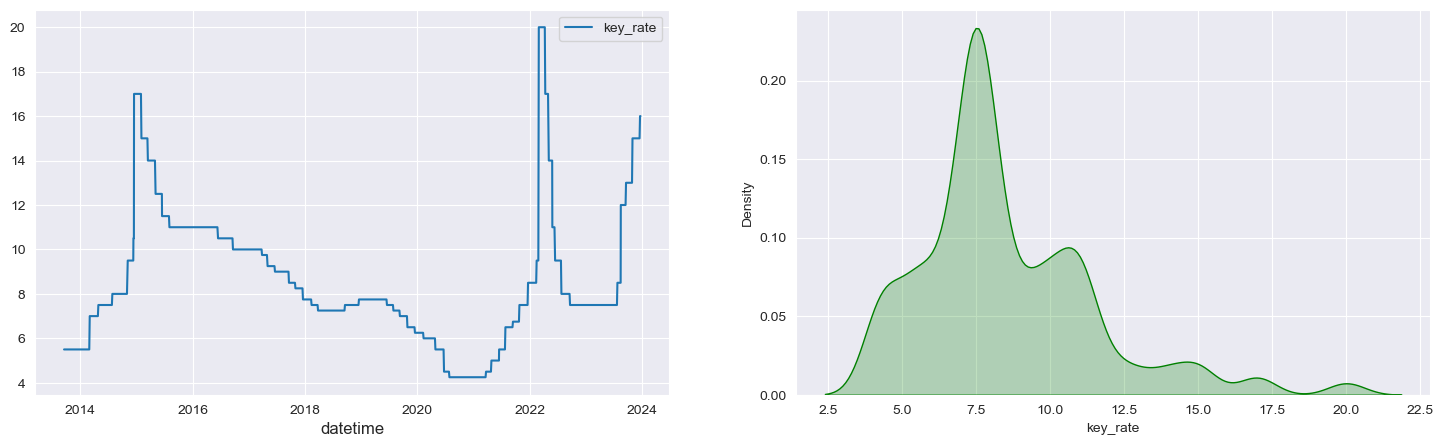

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].plot(df.datetime, df.key_rate, label='key_rate')
axes[0].set_xlabel('datetime', fontsize=12)
axes[0].legend(loc="best")
axes[0].grid(True)

sns.kdeplot(df['key_rate'], ax=axes[1], color='green', fill=True)
axes[1].grid(True)
plt.show()

# 2. Data prepare

In [11]:
df

datetime  key_rate
0    2013-09-17       5.5
1    2013-09-18       5.5
2    2013-09-19       5.5
3    2013-09-20       5.5
4    2013-09-23       5.5
...         ...       ...
2559 2023-12-15      15.0
2560 2023-12-18      16.0
2561 2023-12-19      16.0
2562 2023-12-20      16.0
2563 2023-12-21      16.0

[2564 rows x 2 columns]

In [12]:
print(f'df size = {df.shape}')

df size = (2564, 2)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2564 non-null   datetime64[ns]
 1   key_rate  2564 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.2 KB


In [14]:
df.describe()

key_rate
count  2564.000000
mean      8.506143
std       2.972889
min       4.250000
25%       7.000000
50%       7.750000
75%      10.000000
max      20.000000

In [19]:
df = df.assign(log_rate=np.log(df.key_rate + 1))

In [20]:
df

datetime  key_rate  log_rate
0    2013-09-17       5.5  1.871802
1    2013-09-18       5.5  1.871802
2    2013-09-19       5.5  1.871802
3    2013-09-20       5.5  1.871802
4    2013-09-23       5.5  1.871802
...         ...       ...       ...
2559 2023-12-15      15.0  2.772589
2560 2023-12-18      16.0  2.833213
2561 2023-12-19      16.0  2.833213
2562 2023-12-20      16.0  2.833213
2563 2023-12-21      16.0  2.833213

[2564 rows x 3 columns]

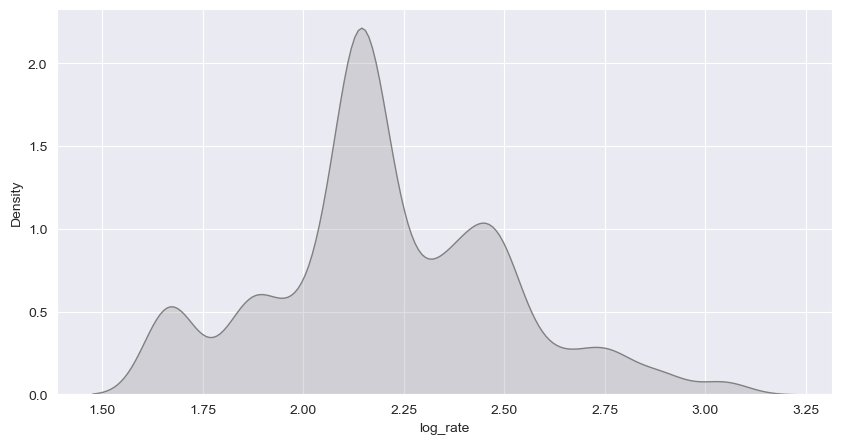

In [21]:
plt.figure(figsize=(10, 5))

sns.kdeplot(df['log_rate'], fill=True, color='grey')
plt.show()

# 3 Preprocessing

In [23]:
def create_features(data_full, col_datetime):
    """Creates time series features"""

    data = data_full.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_type)
    data['quarter'] = data['datetime'].dt.quarter
    data['month'] = data[col_datetime].dt.month
    data['year'] = data[col_datetime].dt.year
    data['date_offset'] = (data[col_datetime].dt.month * 100 +
                           data.datetime.dt.day - 320) % 1300

    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300],
                            labels=['Spring', 'Summer', 'Fall', 'Winter'])
    return data


cat_type = CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
],
    ordered=True)

df_features = create_features(data_full=df, col_datetime='datetime')

In [24]:
df_features[:3]

datetime  key_rate  log_rate    weekday  quarter  month  year  \
0 2013-09-17       5.5  1.871802    Tuesday        3      9  2013   
1 2013-09-18       5.5  1.871802  Wednesday        3      9  2013   
2 2013-09-19       5.5  1.871802   Thursday        3      9  2013   

   date_offset  season  
0          597  Summer  
1          598  Summer  
2          599  Summer

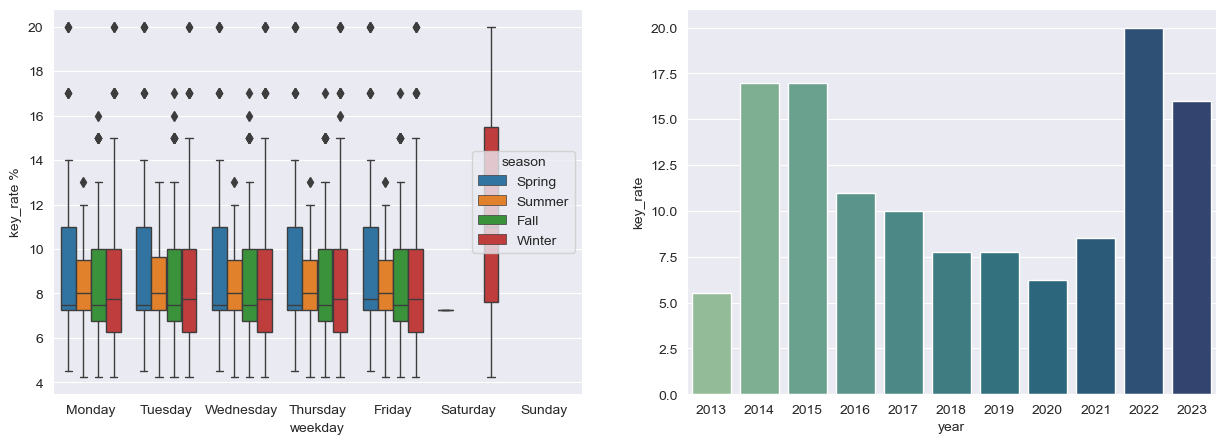

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df_features,
            x='weekday',
            y='key_rate',
            hue='season',
            ax=axes[0],
            linewidth=1)
axes[0].set_xlabel('weekday')
axes[0].set_ylabel('key_rate %')

yearAggregated = pd.DataFrame(df_features.groupby(
    "year")["key_rate"].max()).reset_index().sort_values('key_rate')
sns.barplot(data=yearAggregated, x="year", y="key_rate", palette='crest')
plt.show()

In [27]:
df_features[df_features.weekday == 'Saturday']

datetime  key_rate  log_rate   weekday  quarter  month  year  \
601  2016-02-20     11.00  2.484907  Saturday        1      2  2016   
1141 2018-04-28      7.25  2.110213  Saturday        2      4  2018   
1168 2018-06-09      7.25  2.110213  Saturday        2      6  2018   
1844 2021-02-20      4.25  1.658228  Saturday        1      2  2021   
2108 2022-03-05     20.00  3.044522  Saturday        1      3  2022   

      date_offset  season  
601          1200  Winter  
1141          108  Spring  
1168          289  Spring  
1844         1200  Winter  
2108         1285  Winter

In [28]:
drop_idx = df_features[df_features.weekday == 'Saturday'].index
df = df[~df.index.isin(drop_idx)]
df = df.reset_index(drop=True)

In [29]:
df

datetime  key_rate  log_rate
0    2013-09-17       5.5  1.871802
1    2013-09-18       5.5  1.871802
2    2013-09-19       5.5  1.871802
3    2013-09-20       5.5  1.871802
4    2013-09-23       5.5  1.871802
...         ...       ...       ...
2554 2023-12-15      15.0  2.772589
2555 2023-12-18      16.0  2.833213
2556 2023-12-19      16.0  2.833213
2557 2023-12-20      16.0  2.833213
2558 2023-12-21      16.0  2.833213

[2559 rows x 3 columns]

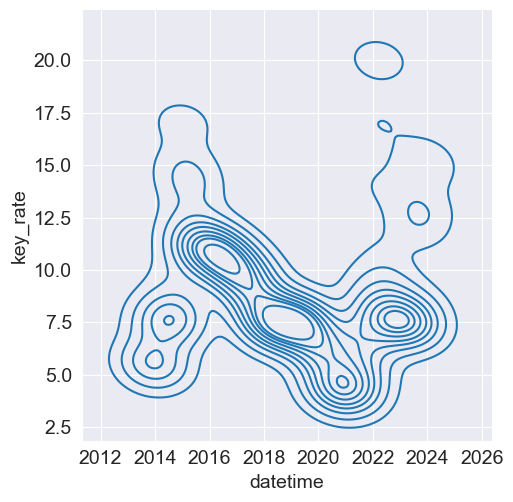

In [30]:
sns.displot(df, x='datetime', y='key_rate', kind="kde", common_norm=False)

plt.xlabel('datetime', fontsize=14)
plt.ylabel('key_rate', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

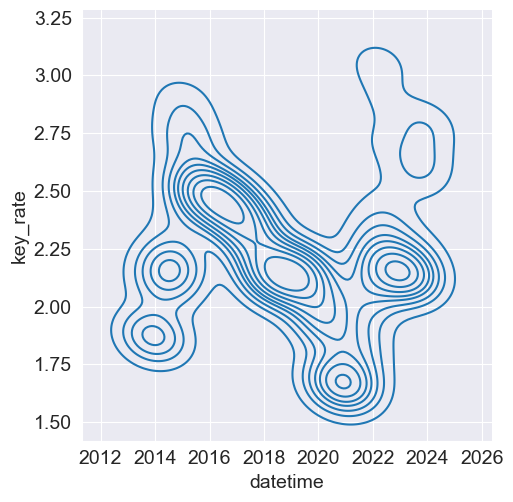

In [31]:
sns.displot(df, x='datetime', y='log_rate', kind="kde", common_norm=False)

plt.xlabel('datetime', fontsize=14)
plt.ylabel('key_rate', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

## 3. Prophet Model

In [37]:
df.columns = ['ds', 'y', 'y_log']
SIZE = int(df.shape[0]*0.1)

train_df = df[:-SIZE]
test_df = df[-SIZE:]

print(train_df.shape)
print(test_df.shape)

(2304, 3)
(255, 3)


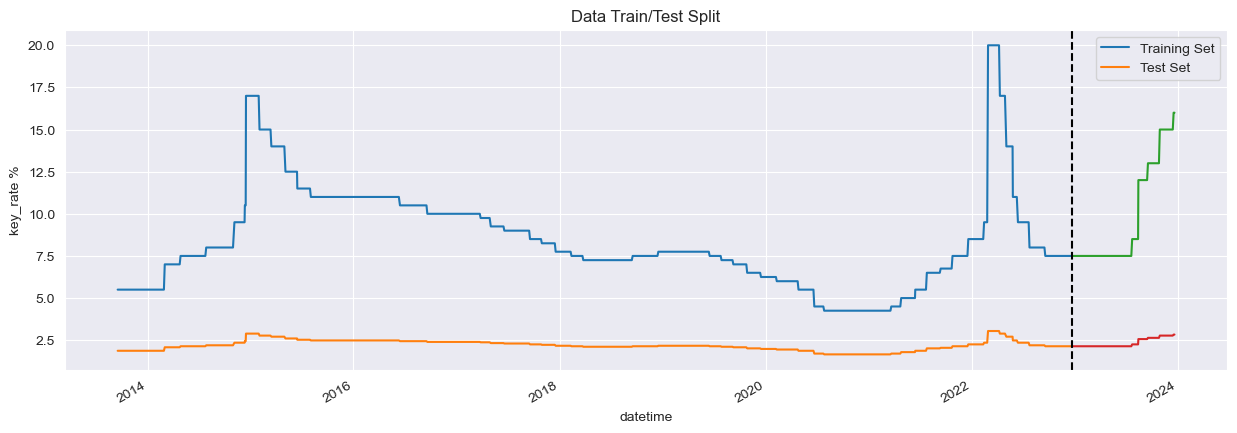

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))

train_df.set_index('ds').plot(ax=ax,
                              label='Train',
                              title='Data Train/Test Split')
test_df.set_index('ds').plot(ax=ax, label='Test')
ax.axvline(train_df['ds'][-1:].values, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('key_rate %')
ax.set_xlabel('datetime')
plt.show()

In [39]:
# changepoint_prior_scale - higher values let have more breaking points
model = Prophet()#changepoint_prior_scale=0.3)

In [41]:
%%time
model.fit(train_df)

11:13:50 - cmdstanpy - INFO - Chain [1] start processing
11:13:51 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 87.9 ms, sys: 22.2 ms, total: 110 ms
Wall time: 1.57 s


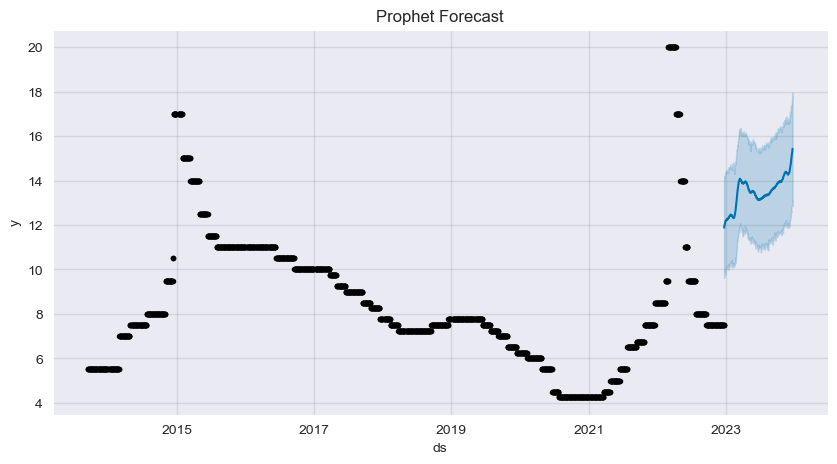

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

predict = model.predict(test_df)
fig = model.plot(predict, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

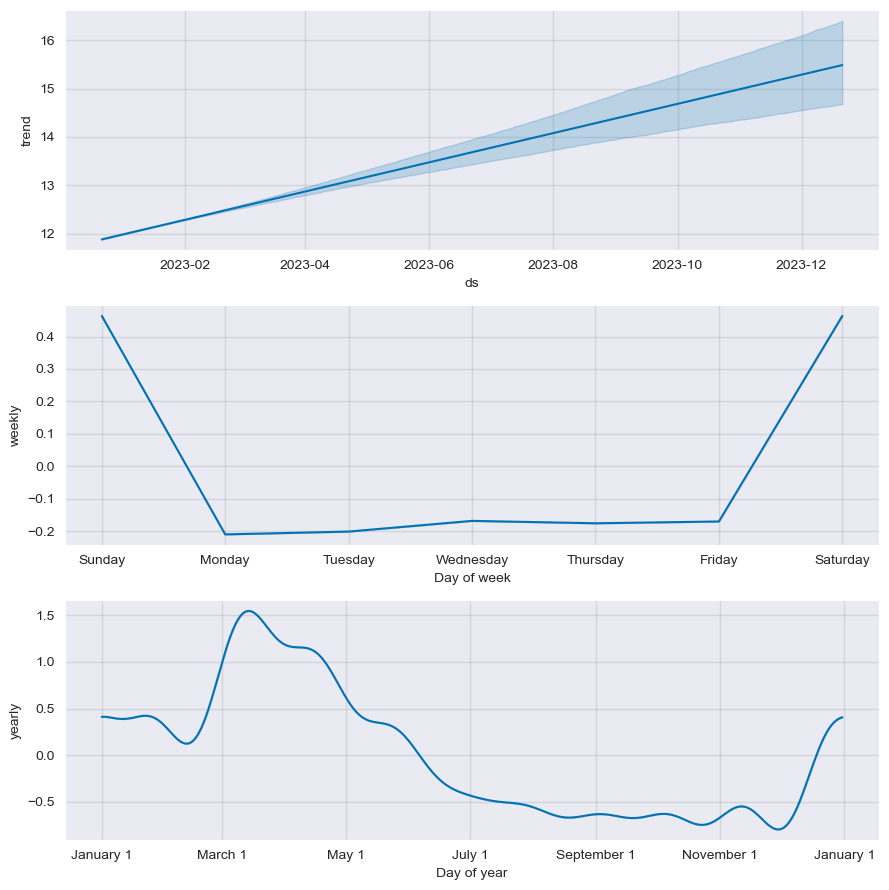

In [43]:
# components decompose
fig = model.plot_components(predict)
plt.show()

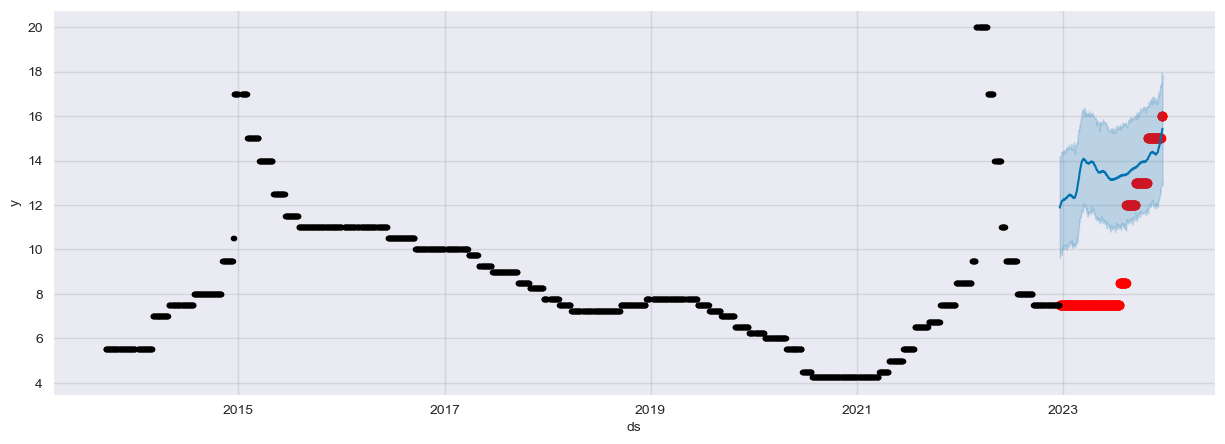

In [46]:
f, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_df.ds, test_df['y'], color='r')
fig = model.plot(predict, ax=ax)

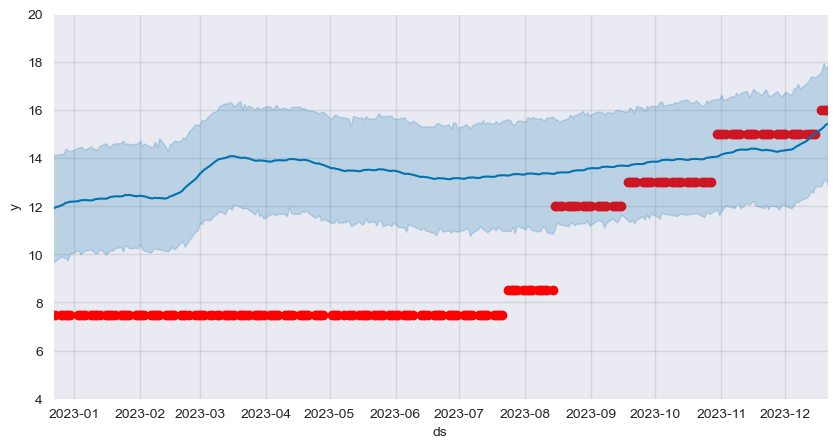

In [47]:
# zoom in
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(test_df.ds, test_df['y'], color='r')
fig = model.plot(predict, ax=ax)
ax.set_xbound(lower=test_df['ds'][:1].values,
              upper=test_df['ds'][-1:].values)
ax.set_ylim(4, 20)
plt.show()

## 4. Evaluate

In [49]:
# result predict dataset
df_test_null = test_df.copy()
df_test_null['y'] = None

df_predict = pd.concat([train_df, df_test_null])
predict = model.predict(df_predict)

In [50]:
mean_absolute_error(y_true=test_df['y'],
                    y_pred=predict['yhat'][train_df.shape[0]:])

3.8991041082629128

In [51]:
mean_absolute_percentage_error(y_true=test_df['y'],
                               y_pred=predict['yhat'][train_df.shape[0]:])

0.49571480796641537

## 5. Future 2024 predict

In [52]:
%%time
model_full = Prophet()#changepoint_prior_scale=0.1)

CPU times: user 1.62 ms, sys: 1.58 ms, total: 3.2 ms
Wall time: 2.02 ms


In [53]:
model_full.fit(df)

11:27:13 - cmdstanpy - INFO - Chain [1] start processing
11:27:14 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
future = model_full.make_future_dataframe(periods=200, freq='D')
forecast = model_full.predict(future)

In [58]:
forecast[df.shape[0]:][:4]

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2559 2023-12-22  11.237145    9.058445   13.607720    11.237145    11.237145   
2560 2023-12-23  11.240350    9.869790   14.479644    11.240350    11.240350   
2561 2023-12-24  11.243554    9.876353   14.591896    11.243554    11.243554   
2562 2023-12-25  11.246759    8.923003   13.580868    11.246759    11.246759   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
2559        0.065275              0.065275              0.065275 -0.249904   
2560        0.910074              0.910074              0.910074  0.611395   
2561        0.889047              0.889047              0.889047  0.611396   
2562       -0.012815             -0.012815             -0.012815 -0.265478   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
2559     -0.249904     -0.249904  0.315179      0.315179      0.315179   
2560      0.611395      0.611395  0.298679      0.298679      0.298679   
2561      0.611396      0.611396  0.277651      0.277651      0.277651   
2562     -0.265478     -0.265478  0.252663      0.252663      0.252663   

      multiplicative_terms  multiplicative_terms_lower  \
2559                   0.0                         0.0   
2560                   0.0                         0.0   
2561                   0.0                         0.0   
2562                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
2559                         0.0  11.302420  
2560                         0.0  12.150423  
2561                         0.0  12.132601  
2562                         0.0  11.233944

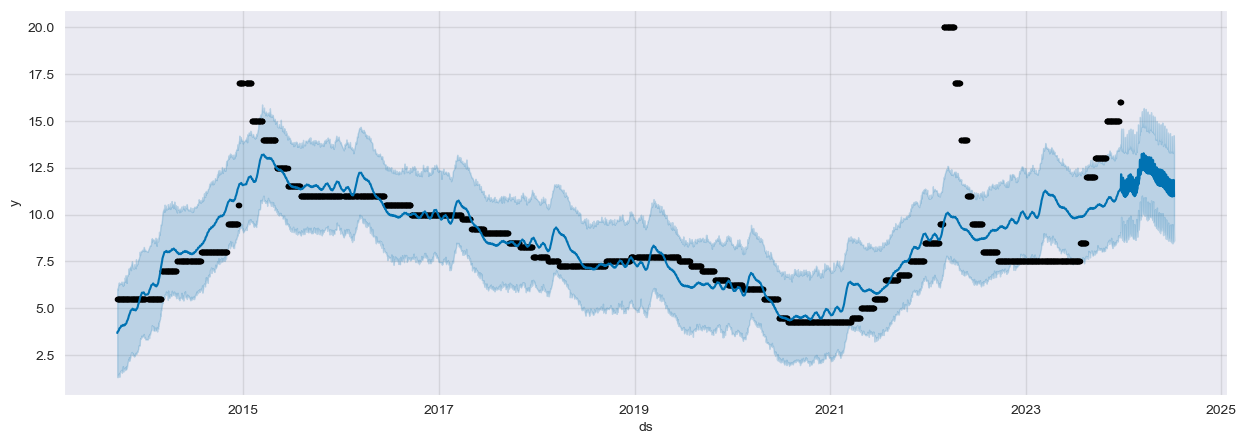

In [59]:
f, ax = plt.subplots(figsize=(15, 5))
fig = model_full.plot(forecast, ax=ax)

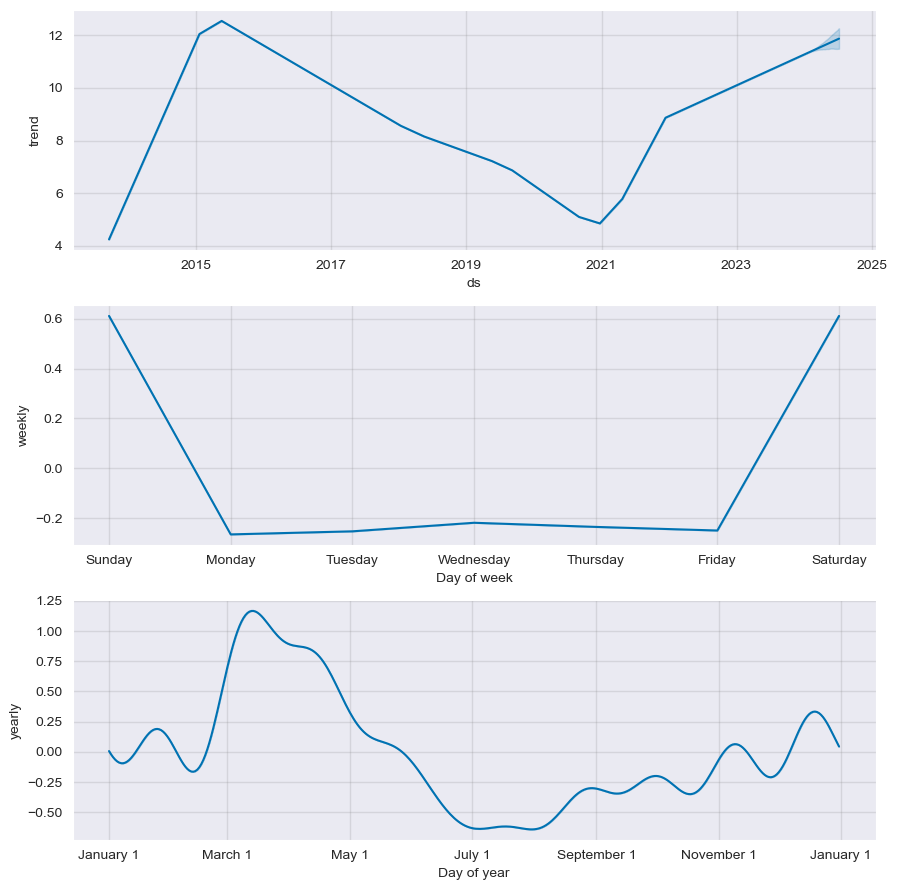

In [60]:
fig = model_full.plot_components(forecast)
plt.show()

## 6. NeuralProphet

In [64]:
from neuralprophet import NeuralProphet

In [65]:
m = NeuralProphet()

In [74]:
train_df = train_df.drop(['y_log'], axis=1)

In [75]:
train_df

ds    y
0    2013-09-17  5.5
1    2013-09-18  5.5
2    2013-09-19  5.5
3    2013-09-20  5.5
4    2013-09-23  5.5
...         ...  ...
2299 2022-12-15  7.5
2300 2022-12-16  7.5
2301 2022-12-19  7.5
2302 2022-12-20  7.5
2303 2022-12-21  7.5

[2304 rows x 2 columns]

In [68]:
test_df

ds     y     y_log
2304 2022-12-22   7.5  2.140066
2305 2022-12-23   7.5  2.140066
2306 2022-12-26   7.5  2.140066
2307 2022-12-27   7.5  2.140066
2308 2022-12-28   7.5  2.140066
...         ...   ...       ...
2554 2023-12-15  15.0  2.772589
2555 2023-12-18  16.0  2.833213
2556 2023-12-19  16.0  2.833213
2557 2023-12-20  16.0  2.833213
2558 2023-12-21  16.0  2.833213

[255 rows x 3 columns]

In [76]:
test_df = test_df.drop(['y_log'], axis=1)

In [77]:
test_df

ds     y
2304 2022-12-22   7.5
2305 2022-12-23   7.5
2306 2022-12-26   7.5
2307 2022-12-27   7.5
2308 2022-12-28   7.5
...         ...   ...
2554 2023-12-15  15.0
2555 2023-12-18  16.0
2556 2023-12-19  16.0
2557 2023-12-20  16.0
2558 2023-12-21  16.0

[255 rows x 2 columns]

In [78]:
metrics = m.fit(train_df, freq="D", epochs=10)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.222% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (36) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.
Missing logger folder: /Users/maksimfomin/IT/DS_practice/1.Регрессия/2.Key_rate_predict_Time_series/notebooks/lightning_logs


Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [80]:
df_predict

ds    y     y_log
0    2013-09-17  5.5  1.871802
1    2013-09-18  5.5  1.871802
2    2013-09-19  5.5  1.871802
3    2013-09-20  5.5  1.871802
4    2013-09-23  5.5  1.871802
...         ...  ...       ...
2554 2023-12-15  NaN  2.772589
2555 2023-12-18  NaN  2.833213
2556 2023-12-19  NaN  2.833213
2557 2023-12-20  NaN  2.833213
2558 2023-12-21  NaN  2.833213

[2559 rows x 3 columns]

In [81]:
df_predict = df_predict.drop(['y_log'], axis=1)

In [82]:
df_predict

ds    y
0    2013-09-17  5.5
1    2013-09-18  5.5
2    2013-09-19  5.5
3    2013-09-20  5.5
4    2013-09-23  5.5
...         ...  ...
2554 2023-12-15  NaN
2555 2023-12-18  NaN
2556 2023-12-19  NaN
2557 2023-12-20  NaN
2558 2023-12-21  NaN

[2559 rows x 2 columns]

In [83]:
predict_neurop = m.predict(df_predict)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 255 rows at the end with NaNs in 'y' column.


Predicting: 36it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [84]:
m.plot(predict_neurop)

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [85]:
m.plot_parameters()

ERROR - (NP.plotly.plot_parameters) - plotly-resampler is not installed. Please install it to use the resampler.


In [86]:
mean_absolute_error(y_true=test_df['y'],
                    y_pred=predict_neurop['yhat1'][train_df.shape[0]:])

2.4895760910183777

In [87]:
mean_absolute_percentage_error(
    y_true=test_df['y'],
    y_pred=predict_neurop['yhat1'][train_df.shape[0]:])

0.21482386696121125

In [89]:
df

ds     y     y_log
0    2013-09-17   5.5  1.871802
1    2013-09-18   5.5  1.871802
2    2013-09-19   5.5  1.871802
3    2013-09-20   5.5  1.871802
4    2013-09-23   5.5  1.871802
...         ...   ...       ...
2554 2023-12-15  15.0  2.772589
2555 2023-12-18  16.0  2.833213
2556 2023-12-19  16.0  2.833213
2557 2023-12-20  16.0  2.833213
2558 2023-12-21  16.0  2.833213

[2559 rows x 3 columns]

In [90]:
df = df.drop(['y_log'], axis=1)

In [91]:
df

ds     y
0    2013-09-17   5.5
1    2013-09-18   5.5
2    2013-09-19   5.5
3    2013-09-20   5.5
4    2013-09-23   5.5
...         ...   ...
2554 2023-12-15  15.0
2555 2023-12-18  16.0
2556 2023-12-19  16.0
2557 2023-12-20  16.0
2558 2023-12-21  16.0

[2559 rows x 2 columns]

In [93]:
NP_model_full = NeuralProphet()

In [94]:
%%time
NP_model_full.fit(df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (40) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.


Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

CPU times: user 5.85 s, sys: 166 ms, total: 6.02 s
Wall time: 6.15 s


MAE       RMSE      Loss  RegLoss  epoch
0   9.464106  11.735659  0.566977      0.0      0
1   7.105573   8.853901  0.394674      0.0      1
2   5.216897   6.489524  0.259967      0.0      2
3   3.577604   4.537211  0.152413      0.0      3
4   2.570811   3.422305  0.094010      0.0      4
..       ...        ...       ...      ...    ...
75  0.964750   1.881849  0.033328      0.0     75
76  0.963771   1.895043  0.033304      0.0     76
77  0.965338   1.875374  0.033311      0.0     77
78  0.964642   1.865711  0.033294      0.0     78
79  0.966159   1.877179  0.033289      0.0     79

[80 rows x 5 columns]

In [97]:
future = NP_model_full.make_future_dataframe(df, periods=365, n_historic_predictions=180)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [98]:
forecast = NP_model_full.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.266% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.266% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 365 rows at the end with NaNs in 'y' column.


Predicting: 40it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [99]:
forecast

ds    y      yhat1      trend  season_yearly  season_weekly
0   2023-04-11  7.5  10.145088  10.558508       0.249561      -0.662980
1   2023-04-12  7.5  10.174976  10.564774       0.243908      -0.633705
2   2023-04-13  7.5  10.152413  10.571037       0.238273      -0.656897
3   2023-04-14  7.5  10.140553  10.577302       0.232701      -0.669450
4   2023-04-17  7.5  10.150805  10.596094       0.216407      -0.661696
..         ...  ...        ...        ...            ...            ...
540 2025-05-09  NaN  14.782722  15.313087       0.136987      -0.667351
541 2025-05-12  NaN  14.799351  15.331882       0.130345      -0.662875
542 2025-05-13  NaN  14.803163  15.338145       0.128034      -0.663017
543 2025-05-14  NaN  14.830626  15.344410       0.125635      -0.639418
544 2025-05-15  NaN  14.822528  15.350674       0.123121      -0.651267

[545 rows x 6 columns]

In [105]:
NP_model_full.plot(forecast)

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [116]:
NP_model_full.plot_components(forecast)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.
